In [783]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns  # 如果想要更方便地可视化混淆矩阵，可以使用 seaborn
from tqdm import tqdm   # 用于进度条
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder

| 方法 | 适用场景 | 优点 | 缺点 |
|------|----------|------|------|
| **方差过滤** | 特征数据较多，但部分特征几乎无变化 | 简单高效 | 可能误删重要特征 |
| **相关性分析** | 需要快速找出与目标变量相关的特征 | 可解释性强 | 仅适用于线性关系 |
| **递归特征消除 (RFE)** | 需要选择固定数量的重要特征 | 适用于各种模型 | 计算量较大 |
| **Lasso (L1 正则化)** | 数据含有冗余特征 | 可自动筛选特征 | 只适用于线性模型 |
| **随机森林特征选择** | 适用于分类问题 | 适用于高维数据 | 计算量大 |
| **LightGBM 重要性** | 数据量大、特征多 | 高效、适用于大规模数据 | 需要调整超参数 |


In [784]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

def rfe_selection(df, target_column, n_features_to_select=5):
    """
    使用RFE（递归特征消除）选择特征
    
    参数:
    df: DataFrame - 输入数据集
    target_column: str - 目标变量列名
    n_features_to_select: int - 选择的特征数量（默认5）
    
    返回:
    selected_features: list - 选出的特征名列表
    """
    X = df.drop([target_column], axis=1)
    y = df[target_column]

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    selector = RFE(model, n_features_to_select=n_features_to_select)
    selector.fit(X, y)
    
    selected_features = X.columns[selector.support_].tolist()
    return selected_features


In [785]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

def lasso_selection(df, target_column, alpha=0.01):
    """
    使用 Lasso 回归进行特征选择
    
    参数:
    df: DataFrame - 输入数据集
    target_column: str - 目标变量列名
    alpha: float - Lasso 回归的正则化参数（默认0.01）
    
    返回:
    selected_features: list - 选出的特征名列表
    """
    X = df.drop([target_column], axis=1)
    y = df[target_column]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_scaled, y)

    selected_features = X.columns[lasso.coef_ != 0].tolist()
    return selected_features


In [786]:
import lightgbm as lgb

def lgbm_feature_selection(df, target_column, num_features=10):
    """
    使用 LightGBM 选择特征
    
    参数:
    df: DataFrame - 输入数据集
    target_column: str - 目标变量列名
    num_features: int - 选择的特征数量（默认10）
    
    返回:
    selected_features: list - 选出的特征名列表
    """
    X = df.drop([target_column], axis=1)
    y = df[target_column]

    model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)

    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    selected_features = feature_importances.nlargest(num_features).index.tolist()
    return selected_features


In [787]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

def select_features_with_rf(df, target_column, test_size=0.3, n_estimators=100, random_state=42):
    """
    使用随机森林进行特征选择
    
    参数:
    df: DataFrame - 输入数据集
    target_column: str - 目标变量列名
    test_size: float - 测试集比例 (默认 0.3)
    n_estimators: int - 随机森林树的数量 (默认 100)
    random_state: int - 随机种子，确保结果可复现 (默认 42)
    
    返回:
    selected_features: list - 选出的特征名列表
    X_train_selected: DataFrame - 训练集筛选后的特征
    X_test_selected: DataFrame - 测试集筛选后的特征
    y_train: Series - 训练集目标变量
    y_test: Series - 测试集目标变量
    """
    
    # 1. 分离特征和目标变量
    #df = pd.read_csv(train_path)
    #X, y = preprocess_data(df)

    X = df.drop([target_column], axis=1)
    y = df[target_column]

    # 2. 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    #print(f"训练集: {X_train.shape}, 测试集: {X_test.shape}")

    # 3. 训练随机森林模型
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X_train, y_train)

    # 4. 使用 SelectFromModel 进行特征选择
    sel = SelectFromModel(rf)
    sel.fit(X_train, y_train)

    # 5. 获取被选中的特征
    selected_features = X_train.columns[sel.get_support()].tolist()


    return selected_features

In [788]:
# -----------------------------------------------------------------------------
# 1. 数据预处理函数
# -----------------------------------------------------------------------------
def preprocess_data(df):
    """
    对数据进行预处理：
    1. 将object类型或可能是字符串类型的特征进行编码（标签编码）
    2. 提取特征X和标签y
    """
    # 假设最后一列class为标签
    # 如果列名为 'class'，则：
    if 'class' not in df.columns:
        raise ValueError("DataFrame 中未找到 'class' 列，请检查数据。")
    
    #df = df.drop(columns=['id', 'attack_cat'])  # 删除无用列

    # 版本 1: Label Encoding (适合决策树、随机森林、XGBoost)
    categorical_columns = ['protocol_type', 'service', 'flag']
    df_label = df.copy()
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df_label[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # 存储编码器，便于逆向转换
    
    print("Label Encoding 完成...")

    # 标准化数值特征（不包括 label）
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numerical_columns.remove('class')  # 不对标签列进行标准化
    
    # 标准化方法
    scaler_standard = StandardScaler()
    scaler_minmax = MinMaxScaler()
    scaler_robust = RobustScaler()

    df_standard = df_label.copy()
    #df_minmax = df_label.copy()
    #df_robust = df_label.copy()

    df_standard[numerical_columns] = scaler_standard.fit_transform(df_standard[numerical_columns])
    
    print("标准化数值特征完成...")
    #df_minmax[numerical_columns] = scaler_minmax.fit_transform(df_minmax[numerical_columns])
    #df_robust[numerical_columns] = scaler_robust.fit_transform(df_robust[numerical_columns])

    #select_features=select_features_with_rf(df_standard, 'label')
    #df_standard=df_standard[select_features+['label']]

    # 分离特征和标签
    #X = df_standard.drop('label', axis=1)
    #y = df_standard['label']

    return df_standard

In [789]:
def preprocess_data_select(df_standard): 
    
    select_features=select_features_with_rf(df_standard, 'class')
    df_standard=df_standard[select_features+['class']]
    
    return df_standard, select_features

In [790]:
# -----------------------------------------------------------------------------
# 2. 模型选择函数
# -----------------------------------------------------------------------------
def choose_model(model_name='RF'):
    """
    根据输入的模型名称，返回对应的机器学习模型实例。
    可根据需求在此扩展更多模型。
    """
    model_name = model_name.lower()
    if model_name == 'dt':
        # 决策树
        return DecisionTreeClassifier(random_state=42)
    elif model_name == 'rf':
        # 随机森林
        return RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_name == 'svm':
        # 支持向量机
        return SVC(kernel='rbf', probability=True, random_state=42)
    elif model_name == 'knn':
        # K近邻
        return KNeighborsClassifier(n_neighbors=5)
    elif model_name == 'gbm':
        # 梯度提升
        return GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    elif model_name == 'lr':
        # 逻辑回归
        return LogisticRegression(max_iter=1000, random_state=42)
    elif model_name == 'xgboost':
        # XGBoost
        return XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    else:
        print(f"未匹配到指定模型 {model_name}，默认使用随机森林 (RF)。")
        return RandomForestClassifier(n_estimators=100, random_state=42)

In [791]:
# -----------------------------------------------------------------------------
# 3. 训练函数
# -----------------------------------------------------------------------------
def train_model(model, train_path):
    """
    使用给定的模型和训练集路径对模型进行训练。
    返回训练好的模型，以及预处理后的训练特征和标签。
    """
    print(f"开始加载训练数据：{train_path}")
    df_train = pd.read_csv(train_path)
    print("开始对训练数据进行预处理...")
    
    df_train = preprocess_data(df_train)
    df_train,select_features= preprocess_data_select(df_train)
    
    # 分离特征和标签
    X_train = df_train.drop('class', axis=1)
    y_train = df_train['class']

    #print(X_train)

    print("开始训练模型...")
    # 这里加一个进度条来模拟训练过程；一般情况下，训练过程本身不一定能直接在tqdm中显示（要看模型是否支持迭代输出）
    for _ in tqdm(range(1), desc="Training"):
        model.fit(X_train, y_train)
    print("训练完成！")
    return model, X_train, y_train ,select_features

In [ ]:
# -----------------------------------------------------------------------------
# 4. 测试函数
# -----------------------------------------------------------------------------
def test_model(model, test_path, select_features, batch_size=1000):
    """
    使用给定的模型和测试集路径对模型进行测试。
    返回评估指标分数，并可视化混淆矩阵。
    使用批量预测来提升速度，同时保留进度条。
    
    参数:
    - model: 训练好的模型
    - test_path: 测试集CSV文件路径
    - batch_size: 每批预测的数据量大小
    """

    print(f"开始加载测试数据：{test_path}")
    df_test = pd.read_csv(test_path)

    print("开始对测试数据进行预处理...")

    df_test = preprocess_data(df_test)
    #print(df_test.columns)
    #df_test, select_features_test= preprocess_data_select(df_test)
    #print(select_features)

    # 分离特征和标签
    X_test = df_test.drop('class', axis=1)
    y_test = df_test['class']
    X_test = X_test[select_features]

    #print(X_test)

    print("开始预测...")
    # 如果不需要进度条，或对小数据集，直接使用 model.predict(X_test) 即可:
    # y_pred = model.predict(X_test)
    #
    # 下面使用批量预测方式 + tqdm 进度条的写法：
    predictions = []
    # range(0, len(X_test), batch_size) 可以把测试集分成若干批次
    for start_idx in tqdm(range(0, len(X_test), batch_size), desc="Predicting"):
        end_idx = min(start_idx + batch_size, len(X_test))
        # 按批次取出数据
        X_batch = X_test.iloc[start_idx:end_idx]
        # 一次预测该批次所有样本
        batch_preds = model.predict(X_batch)
        # 收集到predictions中
        predictions.extend(batch_preds)
    # 转为数组
    y_pred = np.array(predictions)
    # 计算指标
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
    print(f"\n测试结果：\nAccuracy = {acc:.20f}\nPrecision = {precision:.20f}\nRecall = {recall:.20f}\nF1-Score = {f1:.20f}")
    
    '''
    # 可视化混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    '''

    return acc, precision, recall, f1

In [796]:
# -----------------------------------------------------------------------------
# 主流程示例
# -----------------------------------------------------------------------------
selected_model_name = 'RF'  # 'RF', 'SVM', 'KNN', 'GBM', 'DT', 'LR', 'xgboost' 等
model = choose_model(selected_model_name)
# 设置训练集和测试集路径
train_csv_path = 'NSL_KDD_train_split.csv'
# 训练模型
model, X_train, y_train ,select_features = train_model(model, train_csv_path)
#print(select_features)

开始加载训练数据：NSL_KDD_train_split.csv
开始对训练数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始训练模型...


Training: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]

训练完成！


开始加载测试数据：NSL-KDD-Gamma.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 196.06it/s]


测试结果：
Accuracy = 0.80568056805680565713
Precision = 0.92296476306196839623
Recall = 0.70022123893805310324
F1-Score = 0.79630988573225702787


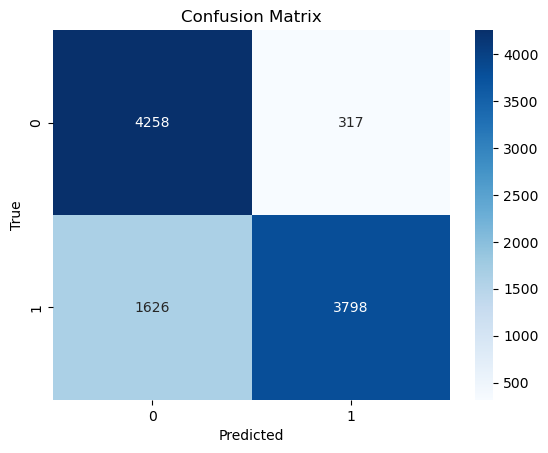

In [ ]:
# 测试模型
# 你可以调整batch_size，如1000、5000、甚至一次性预测
#test_csv_path = 'NSL_KDD_test_split.csv'
#test_csv_path = 'NSL-KDD-Gaussian.csv'
#test_csv_path = 'NSL-KDD-Uniform.csv'
#test_csv_path = 'NSL-KDD-Laplace.csv'
test_csv_path = 'NSL-KDD-Gamma.csv'
#test_csv_path = 'NSL-KDD-Poisson.csv'
#test_csv_path = 'NSL-KDD-Binomial.csv'
#test_csv_path = 'NSL-KDD-Beta.csv'
#test_csv_path = 'NSL-KDD-Cauchy.csv'
acc, precision, recall, f1 = test_model(model, test_csv_path, select_features, batch_size=1000)

Training and testing model: RF
开始加载训练数据：NSL_KDD_train_split.csv
开始对训练数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始训练模型...


Training: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


训练完成！
开始加载测试数据：NSL-KDD-Laplace.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 111.33it/s]



测试结果：
Accuracy = 0.65336533653365336249
Precision = 0.74860335195530725017
Recall = 0.54351032448377578632
F1-Score = 0.62977996154667803541


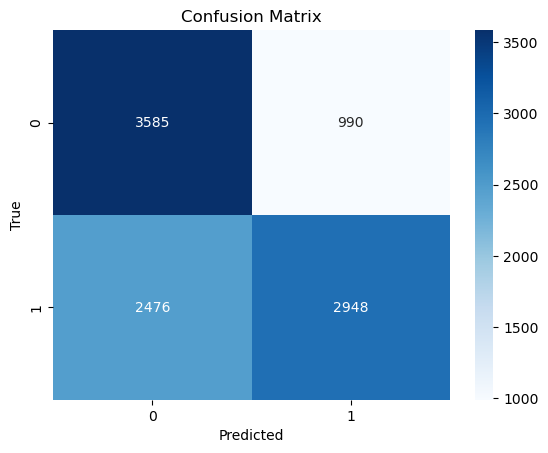

Training and testing model: KNN
开始加载训练数据：NSL_KDD_train_split.csv
开始对训练数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始训练模型...


Training: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


训练完成！
开始加载测试数据：NSL-KDD-Laplace.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


测试结果：
Accuracy = 0.81648164816481649808
Precision = 0.78836573999678616342
Recall = 0.90449852507374628452
F1-Score = 0.84244869923585474769


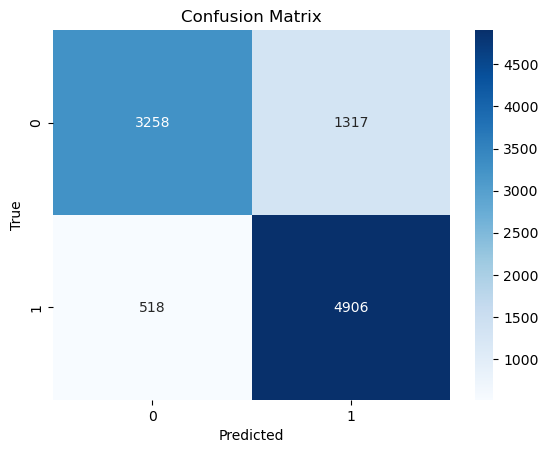

Training and testing model: GBM
开始加载训练数据：NSL_KDD_train_split.csv
开始对训练数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始训练模型...


Training: 100%|██████████| 1/1 [00:07<00:00,  7.85s/it]


训练完成！
开始加载测试数据：NSL-KDD-Laplace.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 465.05it/s]


测试结果：
Accuracy = 0.65166516651665162829
Precision = 0.83407917383820995294
Recall = 0.44671828908554572779
F1-Score = 0.58182254772481689642


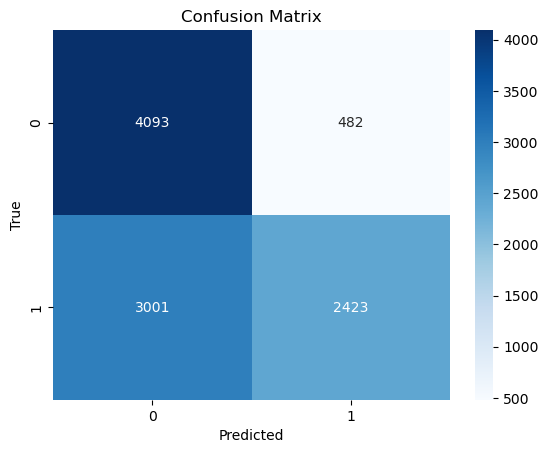

Training and testing model: DT
开始加载训练数据：NSL_KDD_train_split.csv
开始对训练数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始训练模型...


Training: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


训练完成！
开始加载测试数据：NSL-KDD-Laplace.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1450.66it/s]


测试结果：
Accuracy = 0.59355935593559361330
Precision = 0.63854930725346370490
Recall = 0.57780235988200590036
F1-Score = 0.60665892373209451272


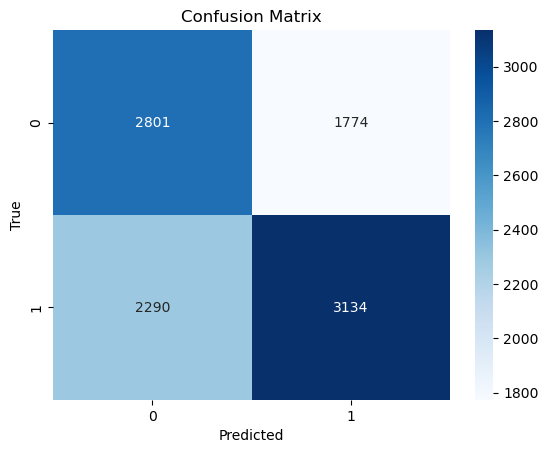

Training and testing model: LR
开始加载训练数据：NSL_KDD_train_split.csv
开始对训练数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始训练模型...


Training: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


训练完成！
开始加载测试数据：NSL-KDD-Laplace.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1866.79it/s]


测试结果：
Accuracy = 0.66846684668466849200
Precision = 0.71982489055659781840
Recall = 0.63661504424778758704
F1-Score = 0.67566774288230113665


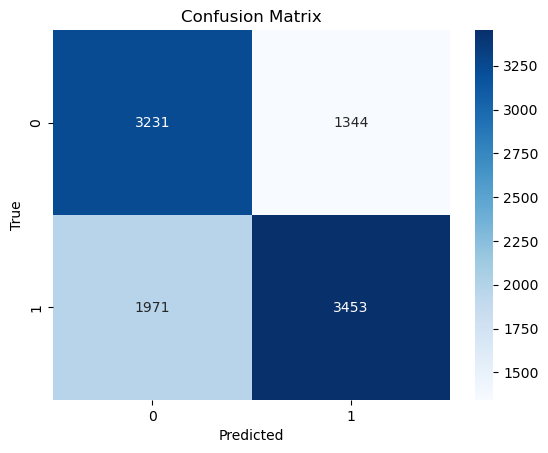

Training and testing model: xgboost
开始加载训练数据：NSL_KDD_train_split.csv
开始对训练数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始训练模型...


Training:   0%|          | 0/1 [00:00<?, ?it/s]d:\Anaconda3\envs\bert_env\lib\site-packages\xgboost\core.py:158: UserWarning: [23:40:08] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
Training: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


训练完成！
开始加载测试数据：NSL-KDD-Laplace.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 200.43it/s]



测试结果：
Accuracy = 0.62966296629662965589
Precision = 0.76583256101328389676
Recall = 0.45704277286135691627
F1-Score = 0.57245121810414500985


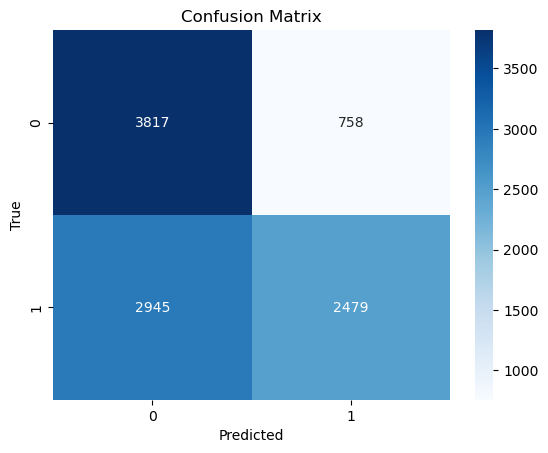


Test Results:
RF: Accuracy=0.6534, Precision=0.7486, Recall=0.5435, F1-score=0.6298
KNN: Accuracy=0.8165, Precision=0.7884, Recall=0.9045, F1-score=0.8424
GBM: Accuracy=0.6517, Precision=0.8341, Recall=0.4467, F1-score=0.5818
DT: Accuracy=0.5936, Precision=0.6385, Recall=0.5778, F1-score=0.6067
LR: Accuracy=0.6685, Precision=0.7198, Recall=0.6366, F1-score=0.6757
xgboost: Accuracy=0.6297, Precision=0.7658, Recall=0.4570, F1-score=0.5725


In [ ]:
model_names = ['RF', 'KNN', 'GBM', 'DT', 'LR', 'xgboost']  # 可更改或扩展模型列表
    
# 训练数据集路径
#test_csv_path = "NSL_KDD_test_split.csv"
#test_csv_path = 'NSL-KDD-Gaussian.csv'
#test_csv_path = 'NSL-KDD-Uniform.csv'
test_csv_path = 'NSL-KDD-Laplace.csv'
#test_csv_path = 'NSL-KDD-Gamma.csv'
#test_csv_path = 'NSL-KDD-Poisson.csv'
#test_csv_path = 'NSL-KDD-Binomial.csv'
#test_csv_path = 'NSL-KDD-Beta.csv'
#test_csv_path = 'NSL-KDD-Cauchy.csv'

    
results = []
    
for model_name in model_names:
        print(f"Training and testing model: {model_name}")
        
        # 选择模型
        model = choose_model(model_name)
        
        # 训练模型
        model, X_train, y_train, select_features = train_model(model, train_csv_path)
        
        # 进行测试
        acc, precision, recall, f1 = test_model(model, test_csv_path, select_features, batch_size=1000)
        results.append((model_name, acc, precision, recall, f1))
    
    # 打印测试结果
print("\nTest Results:")
for model_name, acc, precision, recall, f1 in results:
    print(f"{model_name}: Accuracy={acc:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1:.4f}") 


In [797]:
model_names = ['RF', 'KNN', 'GBM', 'DT', 'LR', 'xgboost']  # 可更改或扩展模型列表
test_files = [
        "NSL_KDD_test_split.csv",
        'NSL-KDD-Gaussian.csv', 
        'NSL-KDD-Uniform.csv', 
        'NSL-KDD-Laplace.csv',
        'NSL-KDD-Gamma.csv', 
        'NSL-KDD-Poisson.csv', 
        'NSL-KDD-Binomial.csv',
        'NSL-KDD-Beta.csv', 
        'NSL-KDD-Cauchy.csv'
    ]
    

results = []
    
for model_name in model_names:
    print(f"Training model: {model_name}")
        
    # 选择模型
    model = choose_model(model_name)
        
    # 训练模型
    model, X_train, y_train, select_features = train_model(model, train_csv_path)
        
    for test_csv_path in test_files:
        print(f"Testing model {model_name} on {test_csv_path}")
        acc, precision, recall, f1 = test_model(model, test_csv_path, select_features, batch_size=1000)
        results.append((model_name, test_csv_path, acc, precision, recall, f1))
    
# 保存结果到 CSV 文件
results_df = pd.DataFrame(results, columns=['Model', 'Test File', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
results_df.to_csv('model_test_results_ml.csv', index=False)
    
# 打印测试结果
print("\nTest Results:")
print(results_df)

Training model: RF
开始加载训练数据：NSL_KDD_train_split.csv
开始对训练数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始训练模型...


Training: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it]


训练完成！
Testing model RF on NSL_KDD_test_split.csv
开始加载测试数据：NSL_KDD_test_split.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 154.84it/s]



测试结果：
Accuracy = 0.94979497949794977618
Precision = 0.98848749503771338176
Recall = 0.91814159292035402160
F1-Score = 0.95201682278722998820
Testing model RF on NSL-KDD-Gaussian.csv
开始加载测试数据：NSL-KDD-Gaussian.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 103.74it/s]


测试结果：
Accuracy = 0.65486548654865484043
Precision = 0.73293978748524202249
Recall = 0.57227138643067843038
F1-Score = 0.64271663733305728350
Testing model RF on NSL-KDD-Uniform.csv
开始加载测试数据：NSL-KDD-Uniform.csv


开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 107.49it/s]



测试结果：
Accuracy = 0.63266326632663261176
Precision = 0.70140326662065788366
Recall = 0.56213126843657812426
F1-Score = 0.62409169992835944463
Testing model RF on NSL-KDD-Laplace.csv
开始加载测试数据：NSL-KDD-Laplace.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 101.08it/s]



测试结果：
Accuracy = 0.65336533653365336249
Precision = 0.74860335195530725017
Recall = 0.54351032448377578632
F1-Score = 0.62977996154667803541
Testing model RF on NSL-KDD-Gamma.csv
开始加载测试数据：NSL-KDD-Gamma.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 107.32it/s]


测试结果：
Accuracy = 0.76627662766276627426
Precision = 0.84646464646464647519
Recall = 0.69524336283185839136
F1-Score = 0.76343759489826901188
Testing model RF on NSL-KDD-Poisson.csv
开始加载测试数据：NSL-KDD-Poisson.csv
开始对测试数据进行预处理...


Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 111.49it/s]



测试结果：
Accuracy = 0.80258025802580257313
Precision = 0.87812362998684789783
Recall = 0.73856932153392329532
F1-Score = 0.80232325255357495042
Testing model RF on NSL-KDD-Binomial.csv
开始加载测试数据：NSL-KDD-Binomial.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 115.62it/s]



测试结果：
Accuracy = 0.88098809880988093735
Precision = 0.93757751136833400452
Recall = 0.83628318584070793218
F1-Score = 0.88403819918144610490
Testing model RF on NSL-KDD-Beta.csv
开始加载测试数据：NSL-KDD-Beta.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 132.98it/s]



测试结果：
Accuracy = 0.88598859885988601182
Precision = 0.91527723924001547218
Recall = 0.87039085545722716386
F1-Score = 0.89226989226989228410
Testing model RF on NSL-KDD-Cauchy.csv
开始加载测试数据：NSL-KDD-Cauchy.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 148.48it/s]



测试结果：
Accuracy = 0.58595859585958598448
Precision = 0.92572944297082226939
Recall = 0.25737463126843657113
F1-Score = 0.40276976341604153742
Training model: KNN
开始加载训练数据：NSL_KDD_train_split.csv
开始对训练数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始训练模型...


Training: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


训练完成！
Testing model KNN on NSL_KDD_test_split.csv
开始加载测试数据：NSL_KDD_test_split.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:01<00:00,  6.02it/s]



测试结果：
Accuracy = 0.96809680968096811782
Precision = 0.96895094616939192456
Recall = 0.97234513274336287214
F1-Score = 0.97064507223704798999
Testing model KNN on NSL-KDD-Gaussian.csv
开始加载测试数据：NSL-KDD-Gaussian.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:02<00:00,  4.45it/s]



测试结果：
Accuracy = 0.81938193819381943683
Precision = 0.78925487687879758436
Recall = 0.91002949852507375450
F1-Score = 0.84535023120397323471
Testing model KNN on NSL-KDD-Uniform.csv
开始加载测试数据：NSL-KDD-Uniform.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]



测试结果：
Accuracy = 0.81118111811181115023
Precision = 0.78433579929237695616
Recall = 0.89915191740412980792
F1-Score = 0.83782855179522419675
Testing model KNN on NSL-KDD-Laplace.csv
开始加载测试数据：NSL-KDD-Laplace.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:02<00:00,  4.48it/s]



测试结果：
Accuracy = 0.81648164816481649808
Precision = 0.78836573999678616342
Recall = 0.90449852507374628452
F1-Score = 0.84244869923585474769
Testing model KNN on NSL-KDD-Gamma.csv
开始加载测试数据：NSL-KDD-Gamma.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:02<00:00,  4.92it/s]



测试结果：
Accuracy = 0.84038403840384034993
Precision = 0.80791505791505791034
Recall = 0.92588495575221241296
F1-Score = 0.86288659793814437293
Testing model KNN on NSL-KDD-Poisson.csv
开始加载测试数据：NSL-KDD-Poisson.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:02<00:00,  4.84it/s]



测试结果：
Accuracy = 0.85848584858485843530
Precision = 0.82737220316838155920
Recall = 0.93399705014749268006
F1-Score = 0.87745734822897725191
Testing model KNN on NSL-KDD-Binomial.csv
开始加载测试数据：NSL-KDD-Binomial.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:02<00:00,  4.95it/s]



测试结果：
Accuracy = 0.91289128912891293055
Precision = 0.90171166401976354798
Recall = 0.94210914454277283614
F1-Score = 0.92146785682084575431
Testing model KNN on NSL-KDD-Beta.csv
开始加载测试数据：NSL-KDD-Beta.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:01<00:00,  5.25it/s]



测试结果：
Accuracy = 0.92759275927592754751
Precision = 0.92114695340501795418
Recall = 0.94764011799410030612
F1-Score = 0.93420574336604866872
Testing model KNN on NSL-KDD-Cauchy.csv
开始加载测试数据：NSL-KDD-Cauchy.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:02<00:00,  4.10it/s]



测试结果：
Accuracy = 0.78647864786478649535
Precision = 0.75141415685674972647
Recall = 0.90615781710914455882
F1-Score = 0.82156289176765562310
Training model: GBM
开始加载训练数据：NSL_KDD_train_split.csv
开始对训练数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始训练模型...


Training: 100%|██████████| 1/1 [00:07<00:00,  7.16s/it]


训练完成！
Testing model GBM on NSL_KDD_test_split.csv
开始加载测试数据：NSL_KDD_test_split.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 567.96it/s]



测试结果：
Accuracy = 0.89108910891089110340
Precision = 0.98349319652018740712
Recall = 0.81286873156342187574
F1-Score = 0.89007772282224684179
Testing model GBM on NSL-KDD-Gaussian.csv
开始加载测试数据：NSL-KDD-Gaussian.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 540.17it/s]



测试结果：
Accuracy = 0.64646464646464651960
Precision = 0.79524851516098782334
Recall = 0.46902654867256637905
F1-Score = 0.59004986663574165995
Testing model GBM on NSL-KDD-Uniform.csv
开始加载测试数据：NSL-KDD-Uniform.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 568.84it/s]



测试结果：
Accuracy = 0.61066106610661063936
Precision = 0.71484703901206847476
Recall = 0.46957964601769913715
F1-Score = 0.56681873817736727617
Testing model GBM on NSL-KDD-Laplace.csv
开始加载测试数据：NSL-KDD-Laplace.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 562.28it/s]


测试结果：
Accuracy = 0.65166516651665162829
Precision = 0.83407917383820995294
Recall = 0.44671828908554572779
F1-Score = 0.58182254772481689642
Testing model GBM on NSL-KDD-Gamma.csv
开始加载测试数据：NSL-KDD-Gamma.csv


开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 555.15it/s]


测试结果：
Accuracy = 0.79657965796579655038
Precision = 0.95296632816675574951
Recall = 0.65744837758112095738
F1-Score = 0.77809295221470653470
Testing model GBM on NSL-KDD-Poisson.csv
开始加载测试数据：NSL-KDD-Poisson.csv


开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 544.26it/s]



测试结果：
Accuracy = 0.82788278827882788580
Precision = 0.96206638382830045320
Recall = 0.71073008849557517408
F1-Score = 0.81751670024387657065
Testing model GBM on NSL-KDD-Binomial.csv
开始加载测试数据：NSL-KDD-Binomial.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 583.42it/s]


测试结果：
Accuracy = 0.83988398839883993130
Precision = 0.97069687269145532582
Recall = 0.72676991150442482592
F1-Score = 0.83120716921454929071
Testing model GBM on NSL-KDD-Beta.csv
开始加载测试数据：NSL-KDD-Beta.csv


开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 525.87it/s]



测试结果：
Accuracy = 0.96059605960596061713
Precision = 0.96062271062271065158
Recall = 0.96699852507374628452
F1-Score = 0.96380007350238883213
Testing model GBM on NSL-KDD-Cauchy.csv
开始加载测试数据：NSL-KDD-Cauchy.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 622.02it/s]



测试结果：
Accuracy = 0.57645764576457647621
Precision = 0.93110949963741840296
Recall = 0.23672566371681416642
F1-Score = 0.37748052329854475673
Training model: DT
开始加载训练数据：NSL_KDD_train_split.csv
开始对训练数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始训练模型...


Training: 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


训练完成！
Testing model DT on NSL_KDD_test_split.csv
开始加载测试数据：NSL_KDD_test_split.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1251.17it/s]



测试结果：
Accuracy = 0.84468446844684463848
Precision = 0.92925260589931246713
Recall = 0.77249262536873153362
F1-Score = 0.84365247155944833590
Testing model DT on NSL-KDD-Gaussian.csv
开始加载测试数据：NSL-KDD-Gaussian.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1331.06it/s]



测试结果：
Accuracy = 0.60426042604260421509
Precision = 0.64954128440366976083
Recall = 0.58738938053097344838
F1-Score = 0.61690386291025267607
Testing model DT on NSL-KDD-Uniform.csv
开始加载测试数据：NSL-KDD-Uniform.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1419.92it/s]



测试结果：
Accuracy = 0.60326032603260326681
Precision = 0.64696388944926364051
Recall = 0.59126106194690264406
F1-Score = 0.61785955110297663406
Testing model DT on NSL-KDD-Laplace.csv
开始加载测试数据：NSL-KDD-Laplace.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1171.99it/s]



测试结果：
Accuracy = 0.59355935593559361330
Precision = 0.63854930725346370490
Recall = 0.57780235988200590036
F1-Score = 0.60665892373209451272
Testing model DT on NSL-KDD-Gamma.csv
开始加载测试数据：NSL-KDD-Gamma.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1425.23it/s]



测试结果：
Accuracy = 0.70137013701370132246
Precision = 0.71853711007529585952
Recall = 0.73893805309734517106
F1-Score = 0.72859480094528272787
Testing model DT on NSL-KDD-Poisson.csv
开始加载测试数据：NSL-KDD-Poisson.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1465.92it/s]


测试结果：
Accuracy = 0.73287328732873291415
Precision = 0.74471111111111110148
Recall = 0.77230825958702065126
F1-Score = 0.75825866594261925879
Testing model DT on NSL-KDD-Binomial.csv
开始加载测试数据：NSL-KDD-Binomial.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...



Predicting: 100%|██████████| 10/10 [00:00<00:00, 1176.46it/s]



测试结果：
Accuracy = 0.77867786778677872128
Precision = 0.79836461624233412415
Recall = 0.79203539823008850540
F1-Score = 0.79518741323461361592
Testing model DT on NSL-KDD-Beta.csv
开始加载测试数据：NSL-KDD-Beta.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1264.45it/s]



测试结果：
Accuracy = 0.41874187418741876110
Precision = 0.47312274868384596171
Recall = 0.62960914454277283614
F1-Score = 0.54026261667457675664
Testing model DT on NSL-KDD-Cauchy.csv
开始加载测试数据：NSL-KDD-Cauchy.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1249.79it/s]



测试结果：
Accuracy = 0.57945794579457943208
Precision = 0.57855393736306226504
Recall = 0.82761799410029501800
F1-Score = 0.68102859743609189813
Training model: LR
开始加载训练数据：NSL_KDD_train_split.csv
开始对训练数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始训练模型...


Training: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


训练完成！
Testing model LR on NSL_KDD_test_split.csv
开始加载测试数据：NSL_KDD_test_split.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1384.44it/s]



测试结果：
Accuracy = 0.93939393939393944777
Precision = 0.94120879120879119561
Recall = 0.94745575221238942376
F1-Score = 0.94432194046306505708
Testing model LR on NSL-KDD-Gaussian.csv
开始加载测试数据：NSL-KDD-Gaussian.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1343.77it/s]



测试结果：
Accuracy = 0.64326432643264330746
Precision = 0.69172000825934343293
Recall = 0.61762536873156337336
F1-Score = 0.65257621505795271322
Testing model LR on NSL-KDD-Uniform.csv
开始加载测试数据：NSL-KDD-Uniform.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1329.50it/s]



测试结果：
Accuracy = 0.60666066606660662419
Precision = 0.65573428034259451103
Recall = 0.57872418879056042318
F1-Score = 0.61482714719420228366
Testing model LR on NSL-KDD-Laplace.csv
开始加载测试数据：NSL-KDD-Laplace.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1428.58it/s]



测试结果：
Accuracy = 0.66846684668466849200
Precision = 0.71982489055659781840
Recall = 0.63661504424778758704
F1-Score = 0.67566774288230113665
Testing model LR on NSL-KDD-Gamma.csv
开始加载测试数据：NSL-KDD-Gamma.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1106.33it/s]



测试结果：
Accuracy = 0.79167916791679171507
Precision = 0.83257017718494918945
Recall = 0.77101769911504425270
F1-Score = 0.80061261606202738239
Testing model LR on NSL-KDD-Poisson.csv
开始加载测试数据：NSL-KDD-Poisson.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1417.90it/s]


测试结果：
Accuracy = 0.81718171817181717298
Precision = 0.85960000000000003073
Recall = 0.79240412979351027012
F1-Score = 0.82463545663852644285
Testing model LR on NSL-KDD-Binomial.csv
开始加载测试数据：NSL-KDD-Binomial.csv
开始对测试数据进行预处理...
Label Encoding 完成...


标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1252.11it/s]


测试结果：
Accuracy = 0.90459045904590462683
Precision = 0.91760089686098655903
Recall = 0.90542035398230091836
F1-Score = 0.91146993318485525215
Testing model LR on NSL-KDD-Beta.csv
开始加载测试数据：NSL-KDD-Beta.csv


开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1422.62it/s]


测试结果：
Accuracy = 0.92659265926592659923
Precision = 0.92823228634039445240
Recall = 0.93713126843657812426
F1-Score = 0.93266055045871554263
Testing model LR on NSL-KDD-Cauchy.csv
开始加载测试数据：NSL-KDD-Cauchy.csv


开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 1000.14it/s]


测试结果：
Accuracy = 0.85858585858585856343
Precision = 0.92860196665241556691
Recall = 0.80088495575221241296
F1-Score = 0.86002771728370619453
Training model: xgboost
开始加载训练数据：NSL_KDD_train_split.csv


开始对训练数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始训练模型...


Training:   0%|          | 0/1 [00:00<?, ?it/s]d:\Anaconda3\envs\bert_env\lib\site-packages\xgboost\core.py:158: UserWarning: [11:50:58] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
Training: 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


训练完成！
Testing model xgboost on NSL_KDD_test_split.csv
开始加载测试数据：NSL_KDD_test_split.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 197.96it/s]



测试结果：
Accuracy = 0.93069306930693074253
Precision = 0.99353223450865846278
Recall = 0.87794985250737467286
F1-Score = 0.93217187041205828990
Testing model xgboost on NSL-KDD-Gaussian.csv
开始加载测试数据：NSL-KDD-Gaussian.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 222.30it/s]



测试结果：
Accuracy = 0.64396439643964398236
Precision = 0.76628571428571423674
Recall = 0.49446902654867258553
F1-Score = 0.60107575078440156346
Testing model xgboost on NSL-KDD-Uniform.csv
开始加载测试数据：NSL-KDD-Uniform.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 185.35it/s]



测试结果：
Accuracy = 0.62766276627662764831
Precision = 0.72807723250201128451
Recall = 0.50055309734513275810
F1-Score = 0.59324811537200916600
Testing model xgboost on NSL-KDD-Laplace.csv
开始加载测试数据：NSL-KDD-Laplace.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 263.24it/s]



测试结果：
Accuracy = 0.62966296629662965589
Precision = 0.76583256101328389676
Recall = 0.45704277286135691627
F1-Score = 0.57245121810414500985
Testing model xgboost on NSL-KDD-Gamma.csv
开始加载测试数据：NSL-KDD-Gamma.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 212.75it/s]



测试结果：
Accuracy = 0.77797779777977793536
Precision = 0.89990014977533694385
Recall = 0.66463864306784659064
F1-Score = 0.76458112407211031858
Testing model xgboost on NSL-KDD-Poisson.csv
开始加载测试数据：NSL-KDD-Poisson.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 210.93it/s]



测试结果：
Accuracy = 0.82178217821782173491
Precision = 0.93172119487908966473
Recall = 0.72455752212389379352
F1-Score = 0.81518357187305534595
Testing model xgboost on NSL-KDD-Binomial.csv
开始加载测试数据：NSL-KDD-Binomial.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 190.28it/s]



测试结果：
Accuracy = 0.86168616861686164743
Precision = 0.96225120109814687996
Recall = 0.77544247787610620648
F1-Score = 0.85880551301684537879
Testing model xgboost on NSL-KDD-Beta.csv
开始加载测试数据：NSL-KDD-Beta.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 240.60it/s]



测试结果：
Accuracy = 0.66436643664366434869
Precision = 0.89255884586180711526
Recall = 0.43344395280235986645
F1-Score = 0.58351948374286422005
Testing model xgboost on NSL-KDD-Cauchy.csv
开始加载测试数据：NSL-KDD-Cauchy.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 10/10 [00:00<00:00, 303.08it/s]


测试结果：
Accuracy = 0.58045804580458049138
Precision = 0.92291810048176192716
Recall = 0.24723451327433629277
F1-Score = 0.38999563763268868533

Test Results:
      Model               Test File  Accuracy  Precision    Recall  F1-score
0        RF  NSL_KDD_test_split.csv  0.949795   0.988487  0.918142  0.952017
1        RF    NSL-KDD-Gaussian.csv  0.654865   0.732940  0.572271  0.642717
2        RF     NSL-KDD-Uniform.csv  0.632663   0.701403  0.562131  0.624092
3        RF     NSL-KDD-Laplace.csv  0.653365   0.748603  0.543510  0.629780
4        RF       NSL-KDD-Gamma.csv  0.766277   0.846465  0.695243  0.763438
5        RF     NSL-KDD-Poisson.csv  0.802580   0.878124  0.738569  0.802323
6        RF    NSL-KDD-Binomial.csv  0.880988   0.937578  0.836283  0.884038
7        RF        NSL-KDD-Beta.csv  0.885989   0.915277  0.870391  0.892270
8        RF      NSL-KDD-Cauchy.csv  0.585959   0.925729  0.257375  0.402770
9       KNN  NSL_KDD_test_split.csv  0.968097   0.968951  0.972345  0.970